<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 20px; height: 55px">

# Project 2: Ames Housing Data and Kaggle Challenge

*All libraries used should be added here*

In [1]:
# Imports:
import pandas as pd
import numpy as np
import scipy.stats as stats #used in Q-Q plot
import math
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression, Lasso, Ridge, LassoCV, RidgeCV, ElasticNet, ElasticNetCV
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.metrics import r2_score, mean_squared_error

import statsmodels.api as sm #used in Q-Q plots

## Data Import

In [59]:
#load dataset again and make the two small changes from EDA notebook
ames = pd.read_csv('./datasets/train.csv')
ames.head()

,Id,PID,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Alley,Lot Shape,Land Contour,...,Screen Porch,Pool Area,Pool QC,Fence,Misc Feature,Misc Val,Mo Sold,Yr Sold,Sale Type,SalePrice
0,109,533352170,60,RL,NaN,13517,Pave,NaN,IR1,Lvl,...,0,0,NaN,NaN,NaN,0,3,2010,WD,130500
1,544,531379050,60,RL,43.0,11492,Pave,NaN,IR1,Lvl,...,0,0,NaN,NaN,NaN,0,4,2009,WD,220000
2,153,535304180,20,RL,68.0,7922,Pave,NaN,Reg,Lvl,...,0,0,NaN,NaN,NaN,0,1,2010,WD,109000
3,318,916386060,60,RL,73.0,9802,Pave,NaN,Reg,Lvl,...,0,0,NaN,NaN,NaN,0,4,2010,WD,174000
4,255,906425045,50,RL,82.0,14235,Pave,NaN,IR1,Lvl,...,0,0,NaN,NaN,NaN,0,3,2010,WD,138500


In [60]:
#reproduce changes from EDA notebook
ames.columns = [col.lower().replace(' ', '_') for col in ames.columns]
ames['ms_subclass'] = 'ms' + ames['ms_subclass'].astype(str)

#save this list for later
drop_col = ['alley', 'fireplace_qu', 'pool_qc', 'fence', 'misc_feature', 
            'garage_cars', '1st_flr_sf', 'garage_yr_blt', 'totrms_abvgrd']

#create our four types
nominal = ['ms_subclass', 'ms_zoning', 'street', 'alley', 'land_contour', 'lot_config', 'neighborhood', 
           'condition_1', 'condition_2', 'bldg_type', 'house_style', 'roof_style', 'roof_matl', 
           'exterior_1st', 'exterior_2nd', 'mas_vnr_type', 'foundation', 'heating', 'central_air', 
           'garage_type', 'misc_feature', 'sale_type']
ordinal = ['lot_shape', 'utilities', 'land_slope', 'exter_qual', 'exter_cond', 'bsmt_qual', 'bsmt_cond', 
           'bsmt_exposure', 'bsmtfin_type_1', 'bsmtfin_type_2', 'heating_qc', 'electrical', 'kitchen_qual', 
           'functional', 'fireplace_qu', 'garage_finish', 'garage_qual', 'garage_cond', 'paved_drive', 
           'pool_qc', 'fence']
discrete = ['year_built', 'year_remod/add', 'overall_qual', 'overall_cond', 'bsmt_full_bath', 'bsmt_half_bath', 
            'full_bath', 'half_bath', 'bedroom_abvgr', 'kitchen_abvgr', 'totrms_abvgrd', 'fireplaces', 
            'garage_yr_blt', 'garage_cars', 'mo_sold', 'yr_sold']
continuous = ['lot_frontage', 'lot_area', 'mas_vnr_area', 'bsmtfin_sf_1', 'bsmtfin_sf_2', 'bsmt_unf_sf', 
              'total_bsmt_sf', '1st_flr_sf', '2nd_flr_sf', 'low_qual_fin_sf', 'gr_liv_area', 'garage_area', 
              'wood_deck_sf', 'open_porch_sf', 'enclosed_porch', '3ssn_porch', 'screen_porch', 'pool_area', 'misc_val']

ames.head(2)

,id,pid,ms_subclass,ms_zoning,lot_frontage,lot_area,street,alley,lot_shape,land_contour,...,screen_porch,pool_area,pool_qc,fence,misc_feature,misc_val,mo_sold,yr_sold,sale_type,saleprice
0,109,533352170,ms60,RL,NaN,13517,Pave,NaN,IR1,Lvl,...,0,0,NaN,NaN,NaN,0,3,2010,WD,130500
1,544,531379050,ms60,RL,43.0,11492,Pave,NaN,IR1,Lvl,...,0,0,NaN,NaN,NaN,0,4,2009,WD,220000


--- 
# Part 2

Part 2 requires knowledge of train/test splitting, feature engineering, and transformers.

---

#### Split DF into X/y and train/test

Even though it feels early, I need to do imputation/OHE on split data

In [4]:
#we also want to remove 'id', 'pid', 'saleprice' from the list of features
drop_col.extend(['id','pid','saleprice'])
drop_col

['alley',
 'fireplace_qu',
 'pool_qc',
 'fence',
 'misc_feature',
 'garage_cars',
 '1st_flr_sf',
 'garage_yr_blt',
 'totrms_abvgrd',
 'id',
 'pid',
 'saleprice']

In [5]:
#split dataframe into X features and y target
y = ames['saleprice']
ames_id = ames['id']
X = ames.drop(columns = drop_col)

print(X.shape, y.shape)
X.head(1)

(2051, 69) (2051,)


,ms_subclass,ms_zoning,lot_frontage,lot_area,street,lot_shape,land_contour,utilities,lot_config,land_slope,...,wood_deck_sf,open_porch_sf,enclosed_porch,3ssn_porch,screen_porch,pool_area,misc_val,mo_sold,yr_sold,sale_type
0,ms60,RL,NaN,13517,Pave,IR1,Lvl,AllPub,CulDSac,Gtl,...,0,44,0,0,0,0,0,3,2010,WD


In [6]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = 0.2, random_state = 199)

X_train.shape, X_val.shape, y_train.shape, y_val.shape

((1640, 69), (411, 69), (1640,), (411,))

In [7]:
# for some reason, whenever I manipulate the DF, all the numeric columns are cast as object types
# this is annoying, so here's a function to try to fix that
# i'll use this for each of the next steps

def df_to_numeric(df):
    for col in df.columns:
        try:
            df[col] = pd.to_numeric(df[col])
        except:
            pass
    return df

#### Imputation

From my EDA, I found 26 features with any null values. I've already dropped 5 of those features because the null threshold was too high (over 25%). I also happened to drop another 2 of those features because they had high collinearity.

I analyzed all of them one by one and researched what they meant in the data dictionary. I determined that almost all of the columns could be imputed with 0 or str('None'). The continuous and discrete features were describing a home with 0 sq_ft or 0 count of an optional feature, and the nominal and ordinal features were describing a home that did not include that optional feature.

Furthermore, the histograms showed that many of these features already had a right skew (many values already filled with '0').  So my imputation would align with the existing data.

This isn't a perfect solution because some of the features have a statistically high number of nulls (like `lot_frontage`: 15%). However, imputing the mean or mode would suggest that these homes DO have the feature, whereas it's their lack of the feature that could be affecting the price.  

I also had one feature which wouldn't make any sense with 0: `garage_yr_blt`. But it is one of the features that got dropped due to collinearity, so I will ignore this problem.

In [8]:
#what are the columns with any nulls
def what_nulls(df):
    return [col for col in df.columns if (df[col].isnull().sum() > 0)]

In [9]:
null_cols = what_nulls(X_train)
print(null_cols)

['lot_frontage', 'mas_vnr_type', 'mas_vnr_area', 'bsmt_qual', 'bsmt_cond', 'bsmt_exposure', 'bsmtfin_type_1', 'bsmtfin_sf_1', 'bsmtfin_type_2', 'bsmtfin_sf_2', 'bsmt_unf_sf', 'total_bsmt_sf', 'bsmt_full_bath', 'bsmt_half_bath', 'garage_type', 'garage_finish', 'garage_area', 'garage_qual', 'garage_cond']


In [10]:
# create simpleImputer function and fill all null values in a column with the best strategy for that column
# fill any numerics with 0 (these are SF or #items)
# fill any categoricals with 'None' (as a str) (these are types or qualities)
col_fill_0 = [col for col in null_cols if (col in X_train._get_numeric_data().columns)]
col_fill_None = [col for col in null_cols if (col in X_train.select_dtypes(include='object').columns)]

ctx_si = ColumnTransformer(
[('si_0', SimpleImputer(strategy='constant', fill_value=0), col_fill_0),
 ('si_None', SimpleImputer(strategy='constant', fill_value='None'), col_fill_None)],
    remainder='passthrough',verbose_feature_names_out=False)

In [11]:
#fit and transform the train set
X_train_imp = ctx_si.fit_transform(X_train)

#only transform the test set
X_val_imp = ctx_si.transform(X_val)

#create DFs
X_train_imp = pd.DataFrame(X_train_imp, columns = ctx_si.get_feature_names_out())
X_val_imp = pd.DataFrame(X_val_imp, columns = ctx_si.get_feature_names_out())

In [12]:
X_train_imp.head(2)

,lot_frontage,mas_vnr_area,bsmtfin_sf_1,bsmtfin_sf_2,bsmt_unf_sf,total_bsmt_sf,bsmt_full_bath,bsmt_half_bath,garage_area,mas_vnr_type,...,wood_deck_sf,open_porch_sf,enclosed_porch,3ssn_porch,screen_porch,pool_area,misc_val,mo_sold,yr_sold,sale_type
0,0.0,0.0,648.0,0.0,0.0,648.0,1.0,1.0,364.0,None,...,88,0,0,0,0,0,0,5,2006,WD
1,26.0,0.0,930.0,0.0,475.0,1405.0,1.0,0.0,522.0,None,...,0,68,0,0,0,0,0,10,2007,WD


#### Feature Engineering

Here I am combining columns that can be added up to an equivalent feature.  I'm also checking some values to verify if that's already done (like total_bsmt_sf and gr_liv_area) so I can drop extra columns.

In [13]:
#checking if total_bsmt_sf is the sum of the previous 3 columns in every observation
tot_bsmt_binary = (X_train_imp.total_bsmt_sf == (X_train_imp.bsmtfin_sf_1+X_train_imp.bsmtfin_sf_2+X_train_imp.bsmt_unf_sf))
print([(i,val) for i, val in enumerate(tot_bsmt_binary) if not val])
#all of them add up exactly

[]


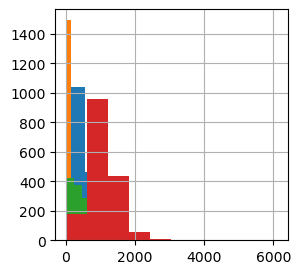

In [14]:
X_train_imp.bsmtfin_sf_1.hist(figsize=(3,3))  #blue
X_train_imp.bsmtfin_sf_2.hist()               #orange
X_train_imp.bsmt_unf_sf.hist()                #green
X_train_imp.total_bsmt_sf.hist();             #red

#I like the idea of keeping only total_bsmt because it has the most normal distribution

I wrote this section of the notebook before I did the pairwise correlation EDA section.  I've since dropped `1st_flr_sf` already, but this section proved to me that I can also drop `2nd_flr_sf` and `low_qual_fin_sf` because `gr_liv_area` describes the data best, and is the most 'normal'.

```
#checking if gr_liv_area is the sum of the previous 3 columns in every observation
gr_la_binary = (X_train_imp.gr_liv_area == (X_train_imp.low_qual_fin_sf+
                X_train_imp['1st_flr_sf']+X_train_imp['2nd_flr_sf']))
print([(i,val) for i, val in enumerate(gr_la_binary) if not val])
#all of them add up exactly
```

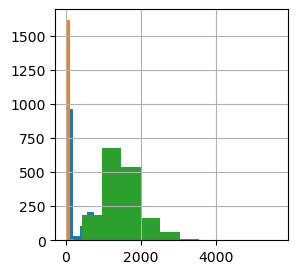

In [15]:
#X_train_imp['1st_flr_sf'].hist()
X_train_imp['2nd_flr_sf'].hist(figsize=(3,3))  #blue
X_train_imp.low_qual_fin_sf.hist()             #orange
X_train_imp.gr_liv_area.hist();                #green

#I like the idea of keeping only gr_liv_area because it has the most normal distribution

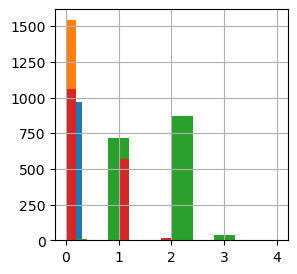

In [16]:
X_train_imp.bsmt_full_bath.hist(figsize=(3,3))  #blue
X_train_imp.bsmt_half_bath.hist()               #orange
X_train_imp.full_bath.hist()                    #green
X_train_imp.half_bath.hist();                   #red

#bsmt_half_bath is a bit more right-skewed than the others, but I think adding them up is a better idea
#keeping bsmt and non-bsmt separate, though

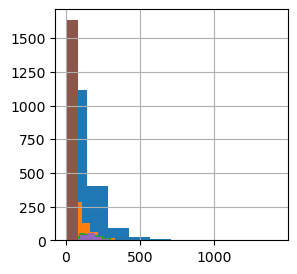

In [17]:
X_train_imp.wood_deck_sf.hist(figsize=(3,3))  #blue   
X_train_imp.open_porch_sf.hist()              #orange
X_train_imp.enclosed_porch.hist()             #green
X_train_imp['3ssn_porch'].hist()              #red
X_train_imp.screen_porch.hist()               #purple
X_train.pool_area.hist();                     #brown

#combining all of these columns would normalize the distribution a lot

In [18]:
sample = X_train_imp[['wood_deck_sf','open_porch_sf','enclosed_porch','3ssn_porch','screen_porch','pool_area']].copy()
df_to_numeric(sample).describe()

#and the values are in similar ranges. 
#The wood deck can get quite large but a combined feature is just describing the overall usable outdoor space

,wood_deck_sf,open_porch_sf,enclosed_porch,3ssn_porch,screen_porch,pool_area
count,1640.000000,1640.000000,1640.000000,1640.000000,1640.000000,1640.000000
mean,93.458537,46.654268,22.604878,2.736585,17.123171,2.324390
std,128.312826,65.187265,60.254048,26.467752,58.360795,37.045274
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,25.500000,0.000000,0.000000,0.000000,0.000000
75%,168.000000,70.000000,0.000000,0.000000,0.000000,0.000000
max,1424.000000,547.000000,432.000000,508.000000,490.000000,800.000000


In [19]:
#combine similar columns that can be added up

def feature_combining(df_prev):
    '''this feature takes in the df (train/val/test) and performs the same FE steps'''
    
    #create new df instead of writing over previous one
    #this allows me to call each df separately if i want, during modeling
    df = df_prev.copy()

    insert_spot = df.columns.get_loc("wood_deck_sf")
    df.insert(insert_spot, "outdoor_fin_sf", 0, True)
    df.outdoor_fin_sf = (df.wood_deck_sf+df.open_porch_sf+df.enclosed_porch
                         +df['3ssn_porch']+df.screen_porch+df.pool_area)

    insert_spot = df.columns.get_loc('full_bath')
    df.insert(insert_spot, "baths", 0, True)
    df.baths = df.full_bath+(df.half_bath/2)
    
    insert_spot = df.columns.get_loc('bsmt_full_bath')
    df.insert(insert_spot, "bsmt_baths", 0, True)
    df.bsmt_baths = df.bsmt_full_bath+(df.bsmt_half_bath/2)
    
    #drop the columns which contributed to our combined features
    df.drop(columns=['wood_deck_sf','open_porch_sf','enclosed_porch','3ssn_porch', 'screen_porch', 'pool_area', 
                     'full_bath','half_bath', 'bsmt_full_bath', 'bsmt_half_bath'],axis=1,inplace=True)
    
    #also drop the columns that we verified are individual components of a sum
    df.drop(columns=['bsmtfin_sf_1', 'bsmtfin_sf_2', 'bsmt_unf_sf', 
                     '2nd_flr_sf', 'low_qual_fin_sf'], axis=1, inplace=True)
    
    return df

In [20]:
#apply feature_combining function to the imputed train/val dataframes
#also apply the df_to_numeric function
X_train_fe = df_to_numeric(feature_combining(X_train_imp))
X_val_fe = df_to_numeric(feature_combining(X_val_imp))

In [21]:
X_train_fe.head(2)

,lot_frontage,mas_vnr_area,total_bsmt_sf,bsmt_baths,garage_area,mas_vnr_type,bsmt_qual,bsmt_cond,bsmt_exposure,bsmtfin_type_1,...,kitchen_abvgr,kitchen_qual,functional,fireplaces,paved_drive,outdoor_fin_sf,misc_val,mo_sold,yr_sold,sale_type
0,0.0,0.0,648.0,1.5,364.0,None,TA,Gd,Av,GLQ,...,1,TA,Typ,0,Y,88,0,5,2006,WD
1,26.0,0.0,1405.0,1.0,522.0,None,Gd,TA,No,GLQ,...,1,Gd,Typ,1,Y,68,0,10,2007,WD


In [22]:
#19/57 columns are numeric, I need to encode the rest
X_train_fe.select_dtypes(exclude='object').head(2)

,lot_frontage,mas_vnr_area,total_bsmt_sf,bsmt_baths,garage_area,lot_area,overall_qual,overall_cond,year_built,year_remod/add,gr_liv_area,baths,bedroom_abvgr,kitchen_abvgr,fireplaces,outdoor_fin_sf,misc_val,mo_sold,yr_sold
0,0.0,0.0,648.0,1.5,364.0,10246,4,9,1965,2001,960,0.0,0,1,0,88,0,5,2006
1,26.0,0.0,1405.0,1.0,522.0,10943,6,5,1997,1998,1337,2.0,2,1,1,68,0,10,2007


#### Ordinal Encoding

**Ordinal Encoding Methodology**

I thought about how to encode the ordinal values for a while.  At first I was thinking it should just be 0 (lowest/worst) to N (highest/best) according to the values mentioned in the data dictionary.  However, after reading a bit more about encoding and ordinal values online, this is the logic I arrived at:

We often evaluate things in terms of **qualitative averages**.  It's not bad, and it's not excellent, it's what I expected.  In terms of housing, I think many people are looking for average qualities across the board.  Ideally they want the best quality, but that comes at a premium.  And they're willing to take something in worse quality, but only at a discount because it would require monetary investment to improve that feature.  So in terms of a home price, I believe a normal distribution of prices aligns with a normal distribution of home quality.  

So I have decided that average quality is mapped to 0, anything above that is a positive value, and anything below that is a negative value.  

For features where the quality falls in a range OR the feature does not exist (ie basement/garage), I considered it this way: A basement is an extra feature. Holding all other features constant, the 'No basement' option is 'normal' and maps to 0, and having an average basement is an additional asset, so it is a positive value. Having an excellent quality basement is even more positive. On the other hand, having a fair or poor quality basement becomes a liability because it requires monetary and time investment from the owner, so those are negative values.

For the features that had unique categories (not just {'Ex', 'Gd', 'TA', 'Fa', 'Po'}), I manually mapped those by reading what each label meant in the data dictionary.

For the most part, these mappings are one-unit changes, because I don't have any quantitative way of saying how much better 'excellent' is compared to 'good'.  I did make adjustments to the 'functional' feature, because of the language used in the dictionary.

*Note on OrdinalEncoder from SKLearn*

I researched and considered using the OrdinalEncoder() from sklearn, but by default it encodes the values in alphabetical order. You can add a dictionary map, but I needed so many different dictionaries for different features that it eventually made more sense to use the manual process below.

In [23]:
#ordinal list was defined at the top of the notebook
#but I am redefining it to remove any columns which were dropped
ordinal = [each for each in ordinal if (each in X_train_fe.columns)]

ord_dict = {each: X_train_fe[each].unique().tolist() for each in ordinal}
ord_dict

{'lot_shape': ['IR1', 'IR2', 'Reg', 'IR3'],
 'utilities': ['AllPub', 'NoSeWa', 'NoSewr'],
 'land_slope': ['Gtl', 'Mod', 'Sev'],
 'exter_qual': ['TA', 'Gd', 'Ex', 'Fa'],
 'exter_cond': ['Gd', 'TA', 'Fa', 'Ex', 'Po'],
 'bsmt_qual': ['TA', 'Gd', 'Ex', 'None', 'Fa', 'Po'],
 'bsmt_cond': ['Gd', 'TA', 'None', 'Fa', 'Ex', 'Po'],
 'bsmt_exposure': ['Av', 'No', 'Mn', 'Gd', 'None'],
 'bsmtfin_type_1': ['GLQ', 'Unf', 'ALQ', 'None', 'BLQ', 'Rec', 'LwQ'],
 'bsmtfin_type_2': ['Unf', 'None', 'Rec', 'GLQ', 'BLQ', 'ALQ', 'LwQ'],
 'heating_qc': ['Ex', 'TA', 'Gd', 'Fa', 'Po'],
 'electrical': ['SBrkr', 'FuseA', 'FuseF', 'FuseP', 'Mix'],
 'kitchen_qual': ['TA', 'Gd', 'Ex', 'Fa'],
 'functional': ['Typ', 'Min1', 'Min2', 'Maj1', 'Maj2', 'Mod', 'Sev', 'Sal'],
 'garage_finish': ['Unf', 'Fin', 'RFn', 'None'],
 'garage_qual': ['TA', 'None', 'Gd', 'Fa', 'Po', 'Ex'],
 'garage_cond': ['TA', 'None', 'Fa', 'Gd', 'Po', 'Ex'],
 'paved_drive': ['Y', 'N', 'P']}

In [24]:
for key, value in ord_dict.items():
    #if it has a 'None' option, the none is set to 0, and average and above is positive, fair and below is negative
    if 'TA' in value and 'None' in value:
        ord_dict[key] = {'Ex':3, 'Gd':2, 'TA':1, 'None':0, 'Fa':-1, 'Po':-2}
    
    #if it doesn't have a 'None' option, the average is set to 0, better than avg is +, and below avg is -
    elif 'TA' in value:
        ord_dict[key] = {'Ex':2, 'Gd':1, 'TA':0, 'Fa':-1, 'Po':-2}
    
    #mapped this using the same logic as the first line: No basement is 0, 
    #a low-quality/unfinished is (-) because it requires $$
    #a basic rec room and anything better is (+)
    elif 'GLQ' in value:
        ord_dict[key] = {'GLQ':4, 'ALQ':3, 'BLQ':2, 'Rec':1, 'None':0, 'LwQ':-1, 'Unf':-2}

#mapped the rest one by one

#a 'regular' lot is normal, and anything worse is a deduction
ord_dict['lot_shape'] = {'Reg':0, 'IR1':-1, 'IR2':-2, 'IR3':-3}

#all utilities is normal, anything less than that is a deduction
ord_dict['utilities'] = {'AllPub':0, 'NoSewr':-1, 'NoSeWa':-2, 'ELO':-3}

#gentle slope is normal, anything worse than that is a deduction
ord_dict['land_slope'] = {'Gtl':0, 'Mod':-1, 'Sev':-2}

#exposure ranges from 'No' (negative) to 'Gd' (positive). 
#'None' correlates to 'no basement', which is conceivably better than 'basement with no exposure'
ord_dict['bsmt_exposure'] = {'Gd':3, 'Av':2, 'Mn':1, 'None':0, 'No':-1}

#average fuse is normal, standard breaker is (+), anything worse is (-)
ord_dict['electrical'] = {'SBrkr':1, 'FuseA':0, 'FuseF':-1, 'FuseP':-2, 'Mix':-3}

#typical is normal, everything else i evaluated in terms of the intensity of the vocab
#1 point deductions for min1/min2/mod each. 
#major is the next step so add an additional deduction for each
#severe is significantly worse, so add an additional deduction
#similarly for salvage, significantly worse than severe
ord_dict['functional'] = {'Typ':0, 'Min1':-1, 'Min2':-2, 'Mod':-3, 'Maj1':-5, 'Maj2':-6, 'Sev':-8, 'Sal':-10}

#'None' correlated to 'no garage' and is normal, some amount of finish is (+) but unfinished is an investment (-)
ord_dict['garage_finish'] = {'Fin':2, 'RFn':1, 'None':0, 'Unf':-1}

#paved (Y) is normal, anything worse is a deduction
ord_dict['paved_drive'] = {'Y':0, 'P':-1, 'N':-2}

#return final mapping dictionary
ord_dict

{'lot_shape': {'Reg': 0, 'IR1': -1, 'IR2': -2, 'IR3': -3},
 'utilities': {'AllPub': 0, 'NoSewr': -1, 'NoSeWa': -2, 'ELO': -3},
 'land_slope': {'Gtl': 0, 'Mod': -1, 'Sev': -2},
 'exter_qual': {'Ex': 2, 'Gd': 1, 'TA': 0, 'Fa': -1, 'Po': -2},
 'exter_cond': {'Ex': 2, 'Gd': 1, 'TA': 0, 'Fa': -1, 'Po': -2},
 'bsmt_qual': {'Ex': 3, 'Gd': 2, 'TA': 1, 'None': 0, 'Fa': -1, 'Po': -2},
 'bsmt_cond': {'Ex': 3, 'Gd': 2, 'TA': 1, 'None': 0, 'Fa': -1, 'Po': -2},
 'bsmt_exposure': {'Gd': 3, 'Av': 2, 'Mn': 1, 'None': 0, 'No': -1},
 'bsmtfin_type_1': {'GLQ': 4,
  'ALQ': 3,
  'BLQ': 2,
  'Rec': 1,
  'None': 0,
  'LwQ': -1,
  'Unf': -2},
 'bsmtfin_type_2': {'GLQ': 4,
  'ALQ': 3,
  'BLQ': 2,
  'Rec': 1,
  'None': 0,
  'LwQ': -1,
  'Unf': -2},
 'heating_qc': {'Ex': 2, 'Gd': 1, 'TA': 0, 'Fa': -1, 'Po': -2},
 'electrical': {'SBrkr': 1, 'FuseA': 0, 'FuseF': -1, 'FuseP': -2, 'Mix': -3},
 'kitchen_qual': {'Ex': 2, 'Gd': 1, 'TA': 0, 'Fa': -1, 'Po': -2},
 'functional': {'Typ': 0,
  'Min1': -1,
  'Min2': -2,
  'Mod

In [25]:
def ordinal_transformer(df_prev):
    '''fn takes in a dataframe (train/val/test), encodes ordinals as discrete integers
    and returns the new df'''
    df = df_prev.copy()
    for key,value in ord_dict.items():
        df[key] = df[key].map(value)
    return df

In [26]:
X_train_oe = df_to_numeric(ordinal_transformer(X_train_fe))
X_val_oe = df_to_numeric(ordinal_transformer(X_val_fe))

#### Run another Correlation Heatmap

Now that I have more numerical features, I want to check correlation and collinearity on them again.

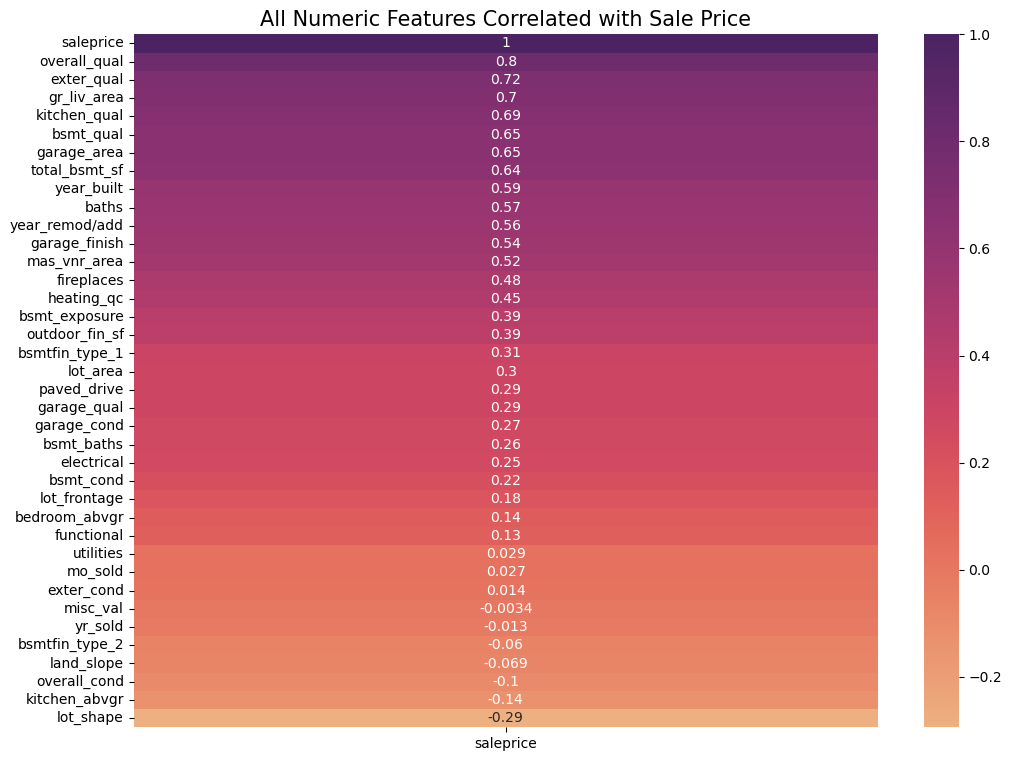

In [27]:
combined = X_train_oe.merge(right=y_train, how='outer', on=y_train.index)
combined.head()

# Create mask for our correlated features
corr = combined.drop(columns=['key_0']).corr()

#Plot heatmap of correlated features.
plt.figure(figsize=(12,9))
mask = np.ones_like(corr)
mask[np.triu_indices_from(mask)] = True

sns.heatmap(corr[['saleprice']].sort_values(by='saleprice',ascending=False), 
            cmap='flare', annot=True)
plt.title('All Numeric Features Correlated with Sale Price', fontsize=15);

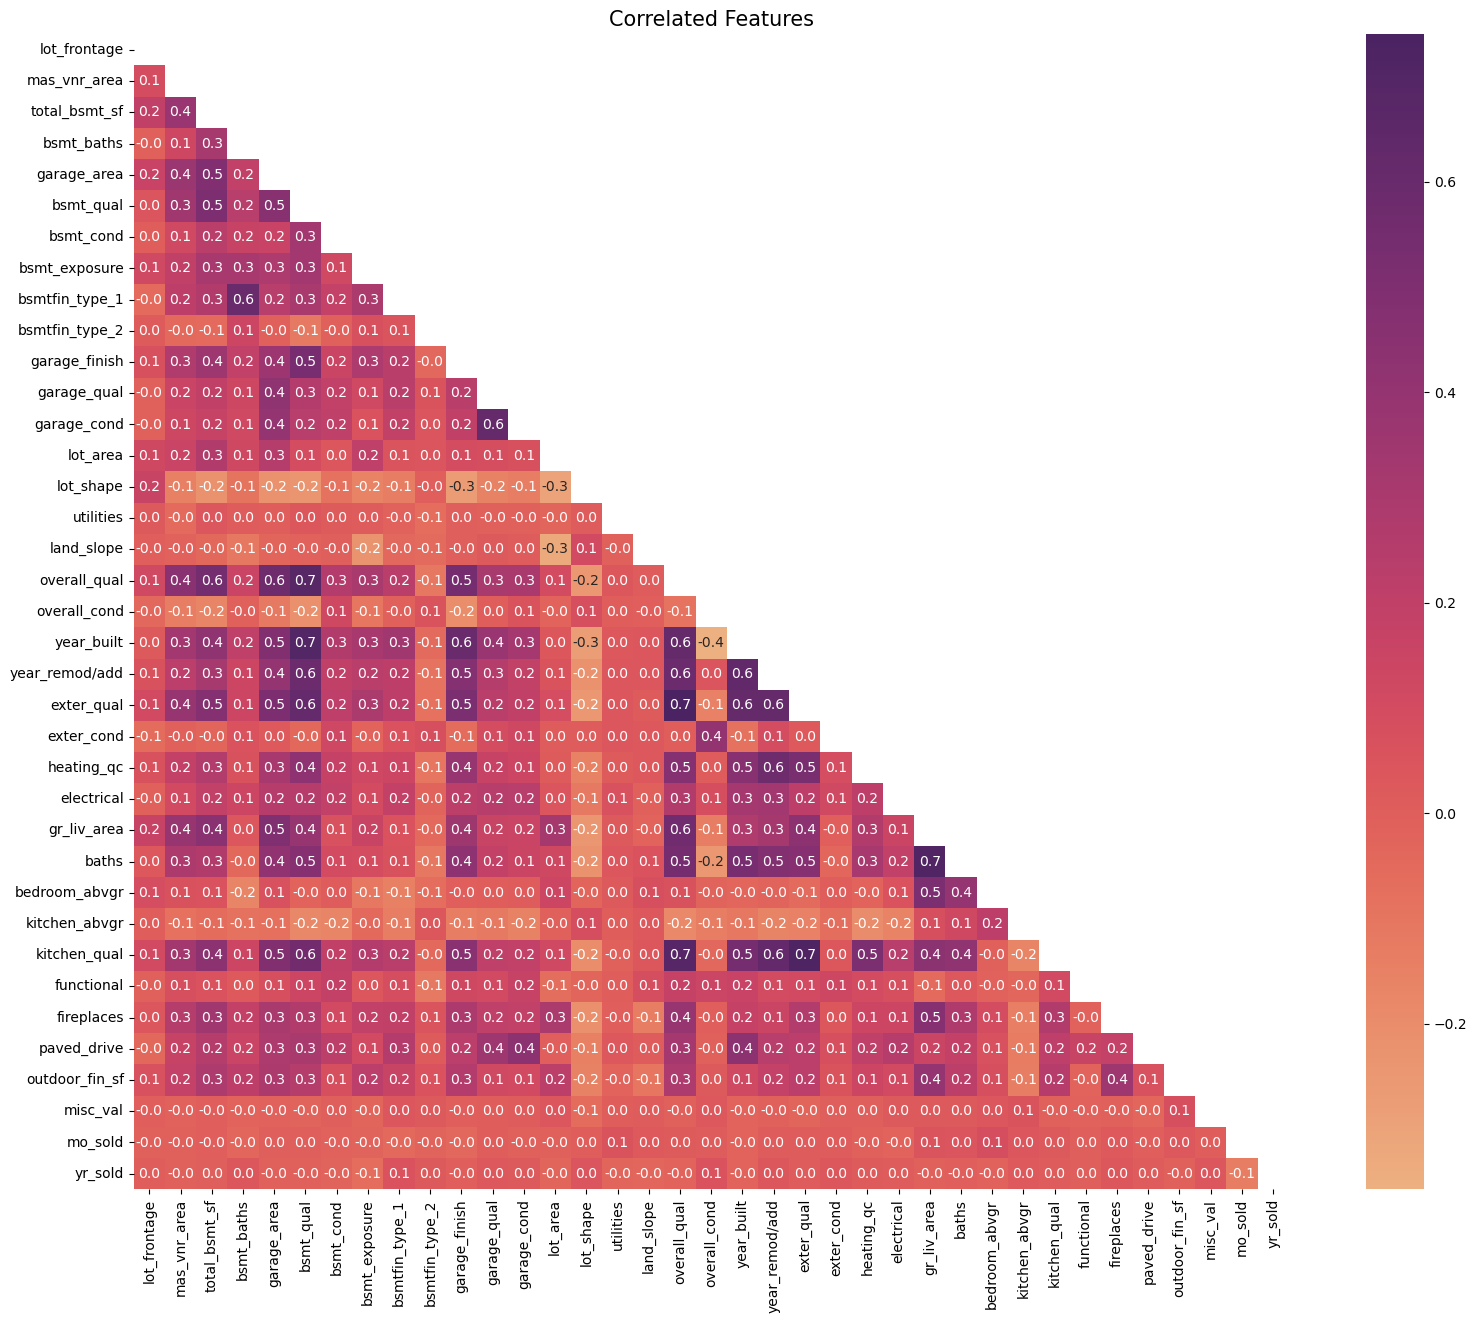

In [28]:
#check pairwise correlation
#this is not trying to compare correlation to SalePrice
top_corr = X_train_oe.corr().index

#Plot heatmap of top twenty positively correlated features.
plt.figure(figsize=(20,15))
mask = np.triu(np.ones_like(X_train_oe[top_corr].corr(), dtype=bool))
ax = sns.heatmap(X_train_oe[top_corr].corr(), cmap='flare', mask=mask, square=True, annot=True, fmt='.1f')
plt.title('Correlated Features', fontsize=15);

The heatmap is actually not indicating any feature with pairwise correlation over 0.75.  So I will keep all the features for now and see if Ridge or Lasso eliminate any.

#### OneHotEncode the nominal data

For the rest of the features in the dataset, we have nominal categorical values (type='object').  I will follow the OneHotEncoder process for these, using the library from sklearn.  Essentially, I want to create binary dummy columns, but dropping the first from each.

In [29]:
#nominal list was defined at top of notebook
#but i'm redefining it to remove any columns which are no longer in the dataframe

nominal = [each for each in nominal if (each in X_train_oe.columns)]

ctx_ohe = ColumnTransformer(
    transformers = [('one_hot',   #alias_first
                     OneHotEncoder(drop = 'first', handle_unknown = 'ignore', sparse = False),   #actual transformer
                     nominal)],   #list_of_cols_to_apply_to 
    remainder = 'passthrough',   #don't drop the others
    verbose_feature_names_out=False)   #don't rename the columns with 'one_hot' prefix

In [30]:
X_train_ohe = ctx_ohe.fit_transform(X_train_oe)
X_val_ohe = ctx_ohe.transform(X_val_oe)

/Users/jahnavik/opt/anaconda3/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [12] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


In [31]:
X_train_ohe = pd.DataFrame(X_train_ohe, columns = ctx_ohe.get_feature_names_out())
X_val_ohe = pd.DataFrame(X_val_ohe, columns = ctx_ohe.get_feature_names_out())

In [32]:
X_train_ohe = df_to_numeric(X_train_ohe)
X_val_ohe = df_to_numeric(X_val_ohe)

X_train_ohe.head(2)

,ms_subclass_ms150,ms_subclass_ms160,ms_subclass_ms180,ms_subclass_ms190,ms_subclass_ms20,ms_subclass_ms30,ms_subclass_ms40,ms_subclass_ms45,ms_subclass_ms50,ms_subclass_ms60,...,bedroom_abvgr,kitchen_abvgr,kitchen_qual,functional,fireplaces,paved_drive,outdoor_fin_sf,misc_val,mo_sold,yr_sold
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,88.0,0.0,5.0,2006.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,2.0,1.0,1.0,0.0,1.0,0.0,68.0,0.0,10.0,2007.0


In [33]:
X_train_ohe.info()

#all of my columns are floats now, which means it's ready for StandardScaling and modeling

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1640 entries, 0 to 1639
Columns: 183 entries, ms_subclass_ms150 to yr_sold
dtypes: float64(183)
memory usage: 2.3 MB


#### Transform (standard scale) the data

In [34]:
ss = StandardScaler()

X_train_ss = ss.fit_transform(X_train_ohe)
X_train_ss = pd.DataFrame(X_train_ss, columns=ss.get_feature_names_out())

X_val_ss = pd.DataFrame(ss.transform(X_val_ohe), columns=ss.get_feature_names_out())

X_train_ss.info()
#dtypes were all transformed into floats after SS performed its mathematical operations

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1640 entries, 0 to 1639
Columns: 183 entries, ms_subclass_ms150 to yr_sold
dtypes: float64(183)
memory usage: 2.3 MB


In [35]:
X_train_ss.describe()
#means are all approximately 0, stds are all approximately 1

,ms_subclass_ms150,ms_subclass_ms160,ms_subclass_ms180,ms_subclass_ms190,ms_subclass_ms20,ms_subclass_ms30,ms_subclass_ms40,ms_subclass_ms45,ms_subclass_ms50,ms_subclass_ms60,...,bedroom_abvgr,kitchen_abvgr,kitchen_qual,functional,fireplaces,paved_drive,outdoor_fin_sf,misc_val,mo_sold,yr_sold
count,1.640000e+03,1.640000e+03,1.640000e+03,1.640000e+03,1.640000e+03,1.640000e+03,1.640000e+03,1.640000e+03,1.640000e+03,1.640000e+03,...,1.640000e+03,1.640000e+03,1.640000e+03,1.640000e+03,1.640000e+03,1.640000e+03,1.640000e+03,1.640000e+03,1.640000e+03,1.640000e+03
mean,3.380765e-16,1.409103e-16,1.237899e-15,-1.197213e-16,-5.647921e-16,-2.744079e-16,-6.478134e-16,6.506144e-16,-6.504282e-16,8.394369e-18,...,4.830147e-17,-3.237248e-16,-1.976739e-17,-2.475323e-16,-3.072745e-16,-1.521818e-16,1.482554e-17,-7.836719e-16,9.355660e-17,-6.395602e-14
std,1.000305e+00,1.000305e+00,1.000305e+00,1.000305e+00,1.000305e+00,1.000305e+00,1.000305e+00,1.000305e+00,1.000305e+00,1.000305e+00,...,1.000305e+00,1.000305e+00,1.000305e+00,1.000305e+00,1.000305e+00,1.000305e+00,1.000305e+00,1.000305e+00,1.000305e+00,1.000305e+00
min,-2.470077e-02,-2.031498e-01,-7.001400e-02,-1.455012e-01,-7.786324e-01,-2.279394e-01,-4.280912e-02,-7.428383e-02,-3.344614e-01,-4.827864e-01,...,-3.434047e+00,-4.999027e+00,-2.273259e+00,-1.153988e+01,-9.263770e-01,-3.415812e+00,-1.095542e+00,-9.735542e-02,-1.895801e+00,-1.369346e+00
25%,-2.470077e-02,-2.031498e-01,-7.001400e-02,-1.455012e-01,-7.786324e-01,-2.279394e-01,-4.280912e-02,-7.428383e-02,-3.344614e-01,-4.827864e-01,...,-1.028307e+00,-1.990245e-01,-7.778137e-01,2.223345e-01,-9.263770e-01,3.113548e-01,-8.111422e-01,-9.735542e-02,-8.143700e-01,-6.015760e-01
50%,-2.470077e-02,-2.031498e-01,-7.001400e-02,-1.455012e-01,-7.786324e-01,-2.279394e-01,-4.280912e-02,-7.428383e-02,-3.344614e-01,-4.827864e-01,...,1.745628e-01,-1.990245e-01,-7.778137e-01,2.223345e-01,6.238865e-01,3.113548e-01,-1.238432e-01,-9.735542e-02,-9.341626e-02,1.661941e-01
75%,-2.470077e-02,-2.031498e-01,-7.001400e-02,-1.455012e-01,1.284303e+00,-2.279394e-01,-4.280912e-02,-7.428383e-02,-3.344614e-01,-4.827864e-01,...,1.745628e-01,-1.990245e-01,7.176312e-01,2.223345e-01,6.238865e-01,3.113548e-01,5.056872e-01,-9.735542e-02,6.275375e-01,9.339643e-01
max,4.048456e+01,4.922476e+00,1.428286e+01,6.872794e+00,1.284303e+00,4.387130e+00,2.335951e+01,1.346188e+01,2.989882e+00,2.071309e+00,...,3.783172e+00,9.400980e+00,2.213076e+00,2.223345e-01,5.274677e+00,3.113548e-01,8.034870e+00,2.701967e+01,2.069445e+00,1.701734e+00


--- 
# Part 3

Part 3 requires knowledge of modeling and cross validation.

---

### Modeling & evaluation!

#### Metrics for evaluation

I will be returning the $R^2$ and $RMSE$ values for each model I generate.  

The default .score() for most of the LinearRegression models is $R^2$ and it's an easier metric to interpret: $X\%$ of the variance in the model can be explained by these features.

$RMSE$ is the metric on Kaggle, so if I track my RMSE's as well, I can check for variance between scoring my training set and the unseen test set.

Here's a dataframe and function for keeping track of scores:

In [36]:
#create a new dataframe with the scores
scores = pd.DataFrame(columns=['model','cross_val_r2','train_r2','val_r2','train_rmse','val_rmse'])
scores.set_index("model", inplace = True)

In [37]:
#create function to add each model scores to df
def new_score(model, model_name):
    '''fn takes in a linear regression (or ridge/lasso model), and a name for the 
    particular model to score. It returns the df updated with the various metrics 
    for that model. This works when the x/y train/test split are already defined.'''
    # import warnings
    # with warnings.catch_warnings():
    #     warnings.simplefilter("ignore")
        
    cv_score = cross_val_score(model, Xs_train, y_train).mean()
    
    r2_train = round(model.score(Xs_train, y_train),3)
    r2_val = round(model.score(Xs_val, y_val),3)

    rmse_train = round(mean_squared_error(y_train, model.predict(Xs_train))**0.5)
    rmse_val = round(mean_squared_error(y_val, model.predict(Xs_val))**0.5)
    
    scores.loc[model_name] = [cv_score, r2_train, r2_val, rmse_train, rmse_val]
    
    return scores

#### Baseline Model

In [38]:
#create your baseline model first!
base_train = [y_train.mean()]*len(y_train)
base_val = [y_train.mean()]*len(y_val)

scores.loc['baseline'] = [None, None, r2_score(y_val, base_val), 
                          round(mean_squared_error(y_train, base_train, squared=False)), 
                          round(mean_squared_error(y_val, base_val, squared=False))]
scores

,cross_val_r2,train_r2,val_r2,train_rmse,val_rmse
model,,,,,
baseline,NaN,NaN,-0.006024,80726.0,73049.0


#### Model Iteration
I created Models for each of the following sets from my final cleaned data.
This is because I built my cleaning backwards.  The code below is only for the final set of models on the dataset with 183 features, but the scores from previous models are saved in the Markdown further down.
1. only columns that were numerics in original dataset (imputation + feature engineering)
2. numerics + encoded ordinals (previous + ordinal encoding)
3. numerics + encoded ordinals + one hot encoded features (previous + one hot encoding)

* apply standard scaling to each set

In [39]:
def model_df_generator(X_train, X_val):
    '''fn takes in set of train/val split, pulls out only numerics, and returns that for modeling'''

    X_train = X_train._get_numeric_data()
    X_val = X_val._get_numeric_data()

    ss = StandardScaler()

    Xs_train = pd.DataFrame(ss.fit_transform(X_train), columns=ss.get_feature_names_out())
    Xs_val = pd.DataFrame(ss.transform(X_val), columns=ss.get_feature_names_out())
    
    return Xs_train, Xs_val

In [40]:
# 1: only original numerics (before other features were encoded)
#Xs_train, Xs_val = model_df_generator(X_train_fe, X_val_fe)

# 2: ordinals encoded now, all numerics
#Xs_train, Xs_val = model_df_generator(X_train_oe, X_val_oe)

# 3: nominals encoded now, all numerics
Xs_train, Xs_val = X_train_ss, X_val_ss

Xs_train.shape, Xs_val.shape, y_train.shape, y_val.shape

((1640, 183), (411, 183), (1640,), (411,))

In [41]:
Xs_train.head(2)

,ms_subclass_ms150,ms_subclass_ms160,ms_subclass_ms180,ms_subclass_ms190,ms_subclass_ms20,ms_subclass_ms30,ms_subclass_ms40,ms_subclass_ms45,ms_subclass_ms50,ms_subclass_ms60,...,bedroom_abvgr,kitchen_abvgr,kitchen_qual,functional,fireplaces,paved_drive,outdoor_fin_sf,misc_val,mo_sold,yr_sold
0,-0.024701,-0.20315,-0.070014,-0.145501,-0.778632,-0.227939,-0.042809,-0.074284,-0.334461,-0.482786,...,-3.434047,-0.199024,-0.777814,0.222335,-0.926377,0.311355,-0.574143,-0.097355,-0.453893,-1.369346
1,-0.024701,-0.20315,-0.070014,-0.145501,-0.778632,-0.227939,-0.042809,-0.074284,-0.334461,-0.482786,...,-1.028307,-0.199024,0.717631,0.222335,0.623887,0.311355,-0.692642,-0.097355,1.348491,-0.601576


#### Linear Regression

In [42]:
#instantiate and fit linear regression model
lr = LinearRegression()
lr.fit(Xs_train, y_train)

lr_cv_score = cross_val_score(lr, Xs_train, y_train).mean()
lr_cv_score

#calculate all scores
new_score(lr, 'LinReg final_features')

,cross_val_r2,train_r2,val_r2,train_rmse,val_rmse
model,,,,,
baseline,NaN,NaN,-0.006024,80726.0,73049.0
LinReg final_features,-6.957780e+22,0.927,0.756000,21831.0,35992.0


This is a really strong $R^2$ score, but it is highly overfit, because there is huge variance between the train and validate sets.  This makes sense because we're using 183 features, and LinReg doesn't remove any.

#### Ridge

In [43]:
import warnings

#try to improve model with regularization
#Ridge

ridge = RidgeCV(alphas = np.logspace(0,5,100))

#fit to scaled training data
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    ridge.fit(Xs_train, y_train)

#what's best alpha
print('Alpha: ', ridge.alpha_)

#get all scores
new_score(ridge, 'Ridge final_features')

Alpha:  376.49358067924675


,cross_val_r2,train_r2,val_r2,train_rmse,val_rmse
model,,,,,
baseline,NaN,NaN,-0.006024,80726.0,73049.0
LinReg final_features,-6.957780e+22,0.927,0.756000,21831.0,35992.0
Ridge final_features,8.648461e-01,0.900,0.811000,25533.0,31643.0


Interestingly, the $R^2$ for the train set is lower here, but the variance compared to the cross_val score and the val_ score is much improved.  This would be considered a 'better' model even though the training scores are ostensibly worse.  But it is ultimately predicting the unseen data (validation set) better than the LinearRegression() is.

#### Lasso

In [44]:
#Lasso
#instantiate it!
lasso = LassoCV(n_alphas=1000)

#fit it!
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    lasso.fit(Xs_train, y_train)

#what's our best alpha?
print('Alpha: ', lasso.alpha_)

#get all scores
new_score(lasso, 'Lasso final_features')

Alpha:  913.4066042257525


,cross_val_r2,train_r2,val_r2,train_rmse,val_rmse
model,,,,,
baseline,NaN,NaN,-0.006024,80726.0,73049.0
LinReg final_features,-6.957780e+22,0.927,0.756000,21831.0,35992.0
Ridge final_features,8.648461e-01,0.900,0.811000,25533.0,31643.0
Lasso final_features,8.541226e-01,0.895,0.822000,26212.0,30691.0


The Lasso regression is performing slightly better than the Ridge.  Again, although the training scores are a bit worse than for the Ridge model, the validation scores have improved.  And the variance is also reduced, because the training and validation scores are closer together.

In [45]:
#we can also analyze the coefficients that were kept with the Lasso Regularization
#Lasso brutally 0's out many of the coefficients

#we can see here that our list of 183 features was reduced to 73!
lasso_coeff = [(round(coeff,2), Xs_train.columns[index]) for index, coeff in enumerate(lasso.coef_) if coeff != 0]
print(len(lasso_coeff))

73


#### ElasticNet

In [46]:
#ElasticNet
#this balances out the higher variance from Ridge and the oversimplification from Lasso

#instantiate it!
enet = ElasticNetCV(alphas=np.arange(0.01,1.0,0.005), l1_ratio=0.5, cv=5, max_iter=5000)

#fit it!
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    enet.fit(Xs_train, y_train)

#what's our best alpha?
print('Alpha: ', enet.alpha_)

#get all scores
new_score(enet, 'ElasticNet final_features')

Alpha:  0.40499999999999997


,cross_val_r2,train_r2,val_r2,train_rmse,val_rmse
model,,,,,
baseline,NaN,NaN,-0.006024,80726.0,73049.0
LinReg final_features,-6.957780e+22,0.927,0.756000,21831.0,35992.0
Ridge final_features,8.648461e-01,0.900,0.811000,25533.0,31643.0
Lasso final_features,8.541226e-01,0.895,0.822000,26212.0,30691.0
ElasticNet final_features,8.652496e-01,0.901,0.811000,25361.0,31703.0


The ElasticNet model is performing very similarly to the Ridge, and appears to be worse than the Lasso model.  The variance is worse (bigger difference between train and val scores).

I can therefore conclude that the Lasso Regularization is the best of the models I have tested.

#### Comparing all the scores

|model|cross_val $R^2$|train $R^2$|val $R^2$|train RMSE (\$)|val RMSE (\$)|
| --- | --- | --- | --- | --- | --- |
baseline|NaN|NaN|-0.006|80726.0|73049.0
LinReg numerics|0.8141|0.826|0.761|33696.0|35579.0
Ridge numerics|0.828|0.847|0.790|31612.0|33412.0
Lasso numerics|0.813|0.825|0.766|33755.0|35210.0
LinReg numerics+ordinals|0.830|0.850|0.779|31307.0|34220.0
Ridge numerics+ordinals|0.828|0.847|0.790|31612.0|33412.0
Lasso numerics+ordinals|0.8301|0.846|0.793|31706.0|33174.0
LinReg_final_features|-6.957780e+22|0.927|0.756|21831.0|35992.0
Ridge_final_features|0.864|0.900|0.811|25533.0|31643.0
**Lasso_final_features**|**0.854**|**0.895**|**0.822**|**26212.0**|**30691.0**
ElasticNet_final_features|0.865|0.901|0.811|25361.0|31703.0

All the scores I have produced during this project are saved here.  I started by testing the LinReg/Lasso/Ridge on only the numeric features.  Then I tested them on numerics+ordinals after encoding the ordinal values.  And finally tested the models on a full set of features that includes numerics, encoded ordinals, and one-hot-encoded nominal values.  The most highly collinear features were also removed from the final round.

The table above shows that each time I changed the features in the Xs_train dataframe, the scores got better. When we only had the numerics, the $val R^2$ scores were in the mid 70%'s. When I changed to numeric+ordinal features, the scores went to the high 70%. And when I chaged to the full set of features (including numerics, encoded ordinals, and one-hot-encoded nominals), the scores increased by comparison.

I also tested the ElasticNet_final_features model to see if it could improve upon Lasso.  It looks like the training score improved,  but the validation score decreased, suggesting a higher variance than the Lasso.

The Lasso Regularization for my final set of features has the best balance of a high score and the lowest variance, but unfortunately the variance is still pretty high.  When I submitted my predictions to Kaggle, I got an RMSE of $29468.95$ which is a slightly better performance than the validation set, but not by much.  

### Testing Linear Assumptions

Next, we want to verify that the MLR we produced is valid as a Linear Regression that describes the data. There are five assumptions we can test.

- Linearity
- Independence of errors
- Normality
- Equality of variance (homoscedasticity)
- No Multicollinearity (Indepedendence of predictors)


We can make an educated guess about the `Independence of Errors`: 
   * We have over 2000 datapoints from the Ames Assessor's office.  
   * The data source does not mention any trends from the data collection process.
   * Although some people (and real-estate investors) might buy multiple properties, homes are large assets and we can therefore assume most of the houses were purchased independently of each other.
   * There is something to be said about the real-estate market following economic fluctuations (like the 2008 recession) which might correlate the number of sales or their prices a bit more.  However we saw in the EDA that there appeared to be no significant relationship between the price and `mo_sold` or `yr_sold`.

In [47]:
#create 'final' model from lasso reg and training data
print('Best alpha: ', lasso.alpha_)
lasso_final = Lasso(alpha = lasso.alpha_)
lasso_final.fit(Xs_train, y_train)

#calculate residuals
y_train_pred = lasso_final.predict(Xs_train)
residuals = y_train - y_train_pred

Best alpha:  913.4066042257525


#### `Linearity` and `Homoscedasticity`

We already looked at linearity a bit in our EDA, but those were just numerous feature vs price plots that look at each feature one by one.  To get another perspective on linearity, we will look at a 'residuals vs fit' plot.  This will also indicate homoscedasticity or not.  If the points are uniformly distributed, it suggests homoscedasticity, but if there are clusters or a pattern, it suggests heteroscedasticity.

From the graph below, it looks like we found a model that accurately depicts a linear relationship with price and is also fairly uniformly distributed around $x=0$. There is less uniformity as our predictions increase, which shows that our model has more error at the more expensive end of the market.  The residuals for higher prices are mostly on the positive side, which specifically tells us that we are **underestimating** the price of more expensive homes.

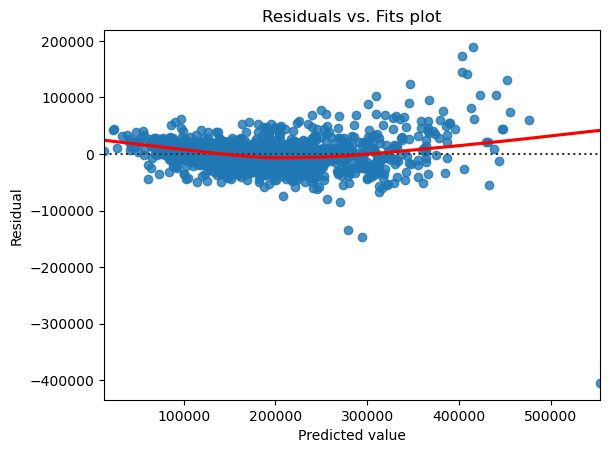

In [48]:
# 'residuals vs fit' plot
sns.residplot(x = y_train_pred, y = residuals, line_kws = {'color' : 'red'}, lowess = True)\
    .set(title = 'Residuals vs. Fits plot',
        xlabel = 'Predicted value',
        ylabel = 'Residual'); 

#### `Normality`

Specifically, we want to know if the errors follow a normal distribution.  We can check with a quantile-quantile plot.

The Q-Q plot shows a linear relationship in the central quartile, but a less linear relationship at the far ends of the plot.  The homoscedasticity plot showed us a similar idea: our model is doing ok at predicting 'average' home prices, but not doing a great job predicting very cheap or very expensive homes.

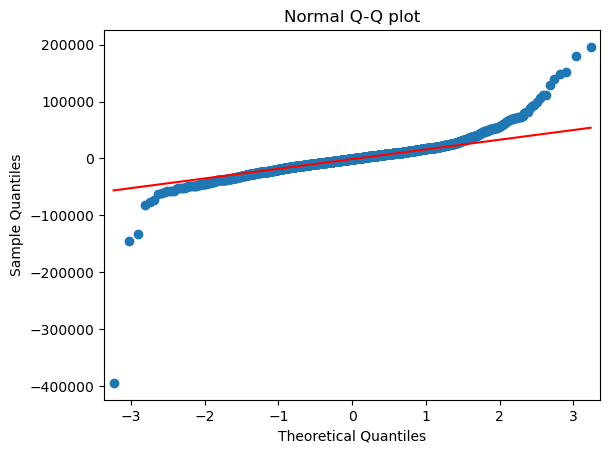

In [49]:
sm.qqplot(residuals,
         dist = stats.norm,
         line = 'q')

plt.title('Normal Q-Q plot');

#### `Multicollinearity`

We looked at this a little bit in the EDA as well.  The correlation heatmap showed some features that were highly correlated to each other, suggesting they would affect the Sale Price collinearly.  At that point, I made the decision to remove 4 features that had the highest pair correlation.  Considering our model is overfitting, it is likely there is still some multicollinearity that I didn't identify (in the nominal values) or set my threshold too low. 

Let's take a look at the VIF data below to see what else is highly correlated.

It looks like almost half (80) of the features have high VIF values and are affecting our model.  A couple are even evaluated as infinite!  This would be the next step I would take in this project.  Iterate through the worst features, remove them one by one and see how the VIF score for the rest of the table changes.  

In [50]:
#define a function to calculate VIF manually
#code is borrowed from the linear assumptions lesson
def calc_vif(data, feats):
    v_df = pd.DataFrame(columns = ['r2', 'tolerance', 'vif'],
                       index = feats)

    for feat in feats: #fit linear models for each independent against all else
        X = data.drop(columns = feat)
        y = data[[feat]]
        
        lr = LinearRegression()
        lr.fit(X, y)
        
        r2 = lr.score(X, y)
        tol = (1 - r2)
        vif = 1/tol
        
        v_df.loc[feat] = [r2, tol, vif]
        
    return v_df.sort_values(by = 'vif', ascending = False)

In [51]:
vif_df = calc_vif(Xs_train, Xs_train.columns)
vif_df[vif_df['vif']>5]

/var/folders/pv/cn5ct9b11714cvj2dp8cp0980000gp/T/ipykernel_83469/3859532660.py:16: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1/tol
/var/folders/pv/cn5ct9b11714cvj2dp8cp0980000gp/T/ipykernel_83469/3859532660.py:16: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1/tol


,r2,tolerance,vif
bldg_type_Duplex,1.0,0.0,inf
ms_subclass_ms90,1.0,0.0,inf
ms_zoning_RL,0.997239,0.002761,362.249747
ms_zoning_RM,0.996357,0.003643,274.526889
ms_subclass_ms20,0.990976,0.009024,110.812018
...,...,...,...
condition_2_Norm,0.833877,0.166123,6.019642
exterior_1st_Stucco,0.82203,0.17797,5.618919
total_bsmt_sf,0.818951,0.181049,5.523373
overall_qual,0.812707,0.187293,5.339236


In [52]:
vif_df[vif_df['vif']>5].index

Index(['bldg_type_Duplex', 'ms_subclass_ms90', 'ms_zoning_RL', 'ms_zoning_RM',
       'ms_subclass_ms20', 'exterior_2nd_VinylSd', 'ms_zoning_FV',
       'ms_subclass_ms60', 'exterior_1st_VinylSd', 'roof_style_Gable',
       'roof_style_Hip', 'exterior_2nd_MetalSd', 'exterior_1st_MetalSd',
       'ms_subclass_ms50', 'house_style_1Story', 'ms_subclass_ms190',
       'house_style_2Story', 'exterior_2nd_CmentBd', 'exterior_2nd_HdBoard',
       'exterior_1st_CemntBd', 'exterior_2nd_Wd Sdng', 'exterior_1st_HdBoard',
       'mas_vnr_type_None', 'ms_subclass_ms80', 'bldg_type_2fmCon',
       'mas_vnr_type_BrkFace', 'roof_matl_CompShg', 'exterior_1st_Wd Sdng',
       'bldg_type_TwnhsE', 'garage_type_Attchd', 'exterior_2nd_Plywood',
       'ms_subclass_ms70', 'house_style_SLvl', 'ms_subclass_ms30',
       'garage_type_Detchd', 'roof_matl_Tar&Grv', 'neighborhood_NAmes',
       'exterior_1st_Plywood', 'ms_zoning_C (all)', 'ms_zoning_RH',
       'neighborhood_OldTown', 'bldg_type_Twnhs', 'year_buil

## Transform and Predict Unseen Data

In [53]:
# import training data now and clean it the same way we did the train/val set
X_test = pd.read_csv('./datasets/test.csv')

#data cleaning
X_test.columns = [col.lower().replace(' ', '_') for col in X_test.columns]
X_test['ms_subclass'] = 'ms' + X_test['ms_subclass'].astype(str)

#stash id column
test_id = X_test['id']

#drop columns with at least 25% nulls and with high collinearity
drop_col.remove('saleprice')
X_test.drop(columns=drop_col, inplace=True)

#are there any nulls not in training data?
print(what_nulls(X_test))

#it looks like electrical has nulls which didn't exist in training, so i'll fill it with the mode
#.mode() isn't working for some reason, so I found mode separately and filled it in
print(X_test.electrical.mode())
X_test['electrical'] = X_test['electrical'].fillna('SBrkr')

X_test.electrical.unique()

['lot_frontage', 'mas_vnr_type', 'mas_vnr_area', 'bsmt_qual', 'bsmt_cond', 'bsmt_exposure', 'bsmtfin_type_1', 'bsmtfin_type_2', 'electrical', 'garage_type', 'garage_finish', 'garage_qual', 'garage_cond']
0    SBrkr
Name: electrical, dtype: object


array(['FuseP', 'SBrkr', 'FuseA', 'FuseF'], dtype=object)

In [54]:
#apply all the same transformers that we applied to train/val set

#impute nulls with 0's and None's
X_test_imp = pd.DataFrame(ctx_si.transform(X_test), columns = ctx_si.get_feature_names_out())

#feature engineering reproduction
X_test_fe = df_to_numeric(feature_combining(X_test_imp))

#ordinal encoding
X_test_oe = df_to_numeric(ordinal_transformer(X_test_fe))

#one hot encoding
X_test_ohe = df_to_numeric(pd.DataFrame(ctx_ohe.transform(X_test_oe), columns = ctx_ohe.get_feature_names_out()))

#standard scale and recreate dataframe
X_test_ss = pd.DataFrame(ss.transform(X_test_ohe), columns=ss.get_feature_names_out())

Xs_test = X_test_ss
print(Xs_test.shape)

(878, 183)


/Users/jahnavik/opt/anaconda3/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [11, 12, 13, 14, 16, 19] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


In [55]:
#make predictions for the test set
preds = lasso_final.predict(Xs_test)
print('shape: ', preds.shape)
preds = pd.DataFrame(preds, columns = ['SalePrice'])
preds.insert(loc=0, column='id', value = test_id)
print(preds)

#save submission csv and drop index
#file name is changed each time I create a new file
preds.to_csv('./datasets/submissions/lasso_5_all_features.csv', index = False)

shape:  (878,)
       id      SalePrice
0    2658  133897.187519
1    2718  157730.879241
2    2414  229569.533706
3    1989  114996.861194
4     625  182216.802158
..    ...            ...
873  1662  189089.080179
874  1234  216589.689194
875  1373  126526.254583
876  1672  106381.310671
877  1939  129789.828033

[878 rows x 2 columns]


--- 
# Part 5

Part 5 requires interpretation and recommendations.

---

## Conclusions and Recommendations

Based on the metrics I chose for evaluation, the Lasso Regularization for my final set of features had the best results.  After submitting my predictions to Kaggle, I received an RMSE score of $29468.95$.  This is worse than my training RMSE score of $26212.0$, but the variance between them is minimized.  All my models scored much better than the baseline at an RMSE of $80726.0$. Therefore I can intuit that my thought process for building a LinearRegression model to predict Housing prices was logical.

The model is still overfitting to the training data, which is likely due to having so many features.  Even though Lasso regularized the features to reduce them from 183 to 54, that looks like it is still too many.

I also saw that there was a lot of multicollinearity left in my 183 features.  We could tinker with the model further by removing the worst offenders one by one and seeing how our score improves or not.

#### Predictions vs Actual

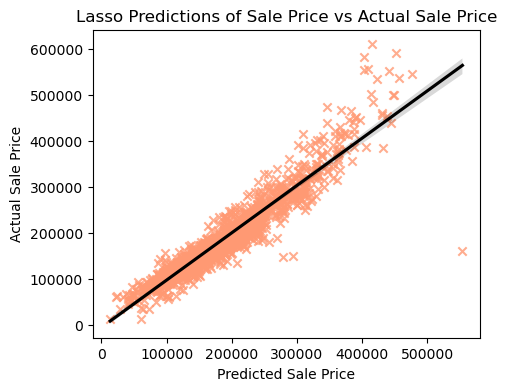

In [56]:
#let's plot a scatterplot to see our 'accuracy': how many prices did we predict correctly?
plt.figure(figsize=(5,4))
sns.regplot(data=Xs_train, x=y_train_pred, y=y_train, marker='x', color='#ff9973', line_kws={'color':'black'})
plt.xlabel('Predicted Sale Price', fontsize=10)
plt.ylabel('Actual Sale Price', fontsize=10)
plt.title('Lasso Predictions of Sale Price vs Actual Sale Price', fontsize=12);

Here we can see that our predictions did follow the actual prices linearly, however the distance from the 'fit line' is pretty big.  A lot of the points have error, as was also seen in the 'residuals vs fit' plot above.  There is also more error at the higher end of the price scale.

#### Understanding our Lasso Coefficients

Even though our model used 183 features, the Lasso Regularization zeroed out more than 100 of them. And we were left with only 73 features which had non-zero coefficients.  Let's look at them a bit further.

In [57]:
coeff_df = pd.DataFrame(columns = ['coeff', 'abs_coeff'])

for (coef, feature) in lasso_coeff:
    coeff_df.loc[feature] = [coef, abs(coef)]

coeff_df.head(2)

,coeff,abs_coeff
ms_subclass_ms150,-364.39,364.39
ms_subclass_ms20,2738.73,2738.73


,coeff
gr_liv_area,21401.95
overall_qual,13815.41
neighborhood_NridgHt,10355.27
neighborhood_StoneBr,7443.26
exter_qual,6803.96


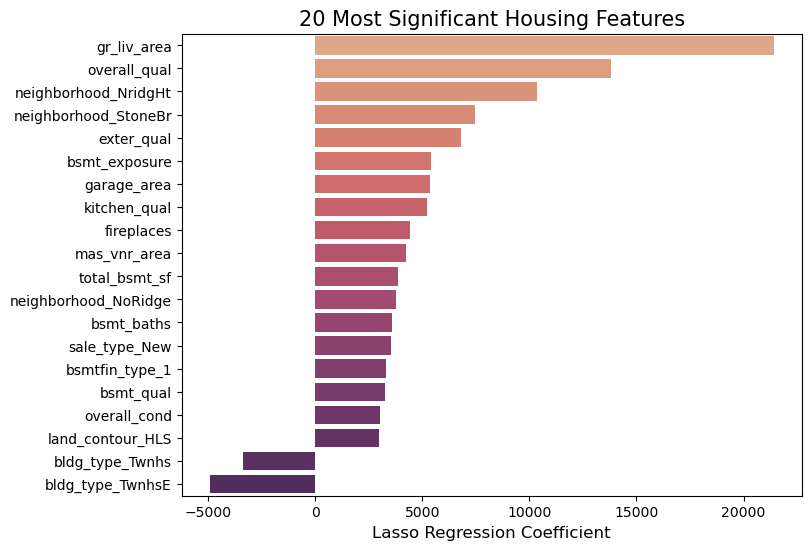

In [58]:
# Plot top 20 features (sorted by absolute regression coefficient)
# code for visualization inspired by another housing regression project online
plt.figure(figsize=(8,6))
data = coeff_df.sort_values(by='abs_coeff', ascending=False)[:20][['coeff']] \
               .sort_values(by='coeff', ascending=False)

ax = sns.barplot(data=data, y=data.index, x='coeff', orient='h', palette='flare')
ax.set_ylabel('')
ax.set_yticklabels(data.index, size=10)
ax.set_xlabel('Lasso Regression Coefficient', fontsize=12)
plt.title('20 Most Significant Housing Features', fontsize=15);

coeff_df.sort_values(by='abs_coeff', ascending=False)[:20][['coeff']].head()

This is a great way to visualize the coefficients.  By themselves, the coefficients are a bit difficult to interpret because our features were standard scaled at the end.  So increasing the `gr_liv_area` by 1 square foot does *not* increase the price by \$21,000.  However, on this graph we can see which features have the biggest impact.  It's also sorted by absolute value first, so the two negative coefficients have a strong negative impact on price.

We can see that the five most significant features are:
|  | coeff|
---|---
gr_liv_area|21401.95
overall_qual|13815.41
neighborhood_NridgHt|10355.27
neighborhood_StoneBr|7443.26
exter_qual|6803.96

* Of those top 5, `gr_liv_area` has more than 3x the impact of `exter_qual`.  

* If you refer back to our correlation matrix in the EDA, the 5 numeric features with the highest correlation were `overall_qual`, `gr_liv_area`, `total_bsmt_sf`, `garage_area`, `garage_cars`.  Those initial predictions do sort of line up with what we see here.  They are all in the Top 20 shown in the graph above (except for `garage_cars` which we dropped due to pairwise correlation).

* The 'quality' features are strong indicators.  `overall_qual`, `exter_qual`, `kitchen_qual`, and `bsmt_qual` all show up.  This shows that qualitative information about the home can be just as useful to the buyers as quantitative measurements of area or number of fireplaces.

* We also see quite a few of the encoded nominal features in this graph.  Three neighborhoods show up \['Northridge Heights', Stone Brook, 'Northridge']. Cross-referencing [information](https://www.neighborhoodscout.com/ia/ames) about Ames neighborhoods does indicate that they are three of the wealthiest neighborhoods in Ames.

**What do our negative coefficients mean?**

* Once we understand our positive coefficients, we can understand that the negative coefficients indicate the opposite.  A home that exists as an end or inside unit of a townhouse will reduce the price, holding all else constant.  

#### Recommendations

* We first recommend iterating and developing this model a bit further to see if we can get a more accurate predictor, especially with less variance. As it stands, we cannot currently recommend offering this as a subscription-based service, because it will not provide enough value to the customer yet. And it is not worth the time investment on our part if we cannot monetize it.
* As a short-term solution, we could build the model if we put caps on the price at either end.  This model does a decent job of predicting prices closer to the median, but the errors get bigger as we look at homes that are potentially either very expensive or very cheap.  Our model tends to underestimate very expensive homes, which could cause issues for a seller who loses money because they assess their home to a lower value than the true.

* We can make the following recommendations to a seller who wants to increase the value of their home before putting it on the market:
    * The total square feet of above-ground living area (sleeping/working/living) has the biggest impact on a home price.  If you have any areas in your home that are unfinished but have the potential to be livable (like an extra storage-only room for example), invest money in remodeling and making those spaces livable or usable beyond storage.
    * Overall quality of the finish and material of the house is another big indicator.  For example, if you have old-fashioned wood siding outside your home, consider getting it replaced by the more modern stucco siding.
    * Townhouses are some of the strongest *negative* indicators of price.  If you are unfortunately trying to sell a townhouse, definitely make sure to invest money where you can to increase the above-ground living area or improve the overall quality.  That effort will be necessary to get a good price on your sale.